# MNIST Number Generator GAN

### Function
In this notebook, MNIST dataset has been used to train two linear Generator and Discriminator network in order to implement a GAN that can generate different hand-written digits

### Implementation details
1.   The generator and discriminator components of a GAN has been built from scratch.
2.   generator and discriminator loss functions have been implemented.
3.   GAN has been trained and visualized the generated images.


## Importing useful packages
A visualizer function has been defined to investigate the images the GAN will create.


In [1]:
import torch
from torch import nn
from tqdm.auto import tqdm
from torchvision import transforms
from torchvision.datasets import MNIST # Training dataset
from torchvision.utils import make_grid
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
torch.manual_seed(0) # Set for testing purposes, please do not change!

def show_tensor_images(image_tensor, num_images=25, size=(1, 28, 28)):
    '''
    Function for visualizing images: Given a tensor of images, number of images, and
    size per image, plots and prints the images in a uniform grid.
    '''
    image_unflat = image_tensor.detach().cpu().view(-1, *size)
    image_grid = make_grid(image_unflat[:num_images], nrow=5)
    plt.imshow(image_grid.permute(1, 2, 0).squeeze())
    plt.show()

#### MNIST Dataset
The training images the discriminator will be using is from a dataset called [MNIST](http://yann.lecun.com/exdb/mnist/). It contains 60,000 images of handwritten digits, from 0 to 9, like these:

![MNIST Digits](MnistExamples.png)

You may notice that the images are quite pixelated -- this is because they are all only 28 x 28! The small size of its images makes MNIST ideal for simple training. Additionally, these images are also in black-and-white so only one dimension, or "color channel", is needed to represent them (more on this later in the course).

## Generator
1. Building the generator's basic linear building block
2. Using generator blocks to build the generator

In [2]:
def get_generator_block(input_dim, output_dim):
    '''
    Function for returning a block of the generator's neural network
    given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a generator neural network layer, with a linear transformation 
          followed by a batch normalization and then a relu activation
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.BatchNorm1d(output_dim),
        nn.ReLU(inplace=True)
    )

Now it is possible to build the generator. It will take 3 values:

*   The noise vector dimension
*   The image dimension
*   The initial hidden dimension

Using these values, the generator will build a neural network with 5 layers/blocks. Beginning with the noise vector, the generator will apply non-linear transformations via the block function until the tensor is mapped to the size of the image to be outputted (the same size as the real images from MNIST). The final layer does not need a normalization or activation function, but does need to be scaled with a sigmoid function. 

In [7]:
class Generator(nn.Module):
    '''
    Generator Class
    Values:
        z_dim: the dimension of the noise vector, a scalar
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
          (MNIST images are 28 x 28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, z_dim=10, im_dim=784, hidden_dim=128):
        super(Generator, self).__init__()
        self.gen = nn.Sequential(
            get_generator_block(z_dim, hidden_dim),
            get_generator_block(hidden_dim, hidden_dim * 2),
            get_generator_block(hidden_dim * 2, hidden_dim * 4),
            get_generator_block(hidden_dim * 4, hidden_dim * 8),
            nn.Linear(hidden_dim*8, im_dim),
            nn.Sigmoid()
        )
    def forward(self, noise):
        '''
        Function for completing a forward pass of the generator: Given a noise tensor, 
        returns generated images.
        Parameters:
            noise: a noise tensor with dimensions (n_samples, z_dim)
        '''
        return self.gen(noise)

## Noise
To be able to use the generator, it is needed to be able to create noise vectors. The noise vector z has the important role of making sure the images generated from the same class don't all look the same.

In [11]:
def get_noise(n_samples, z_dim, device='cpu'):
    '''
    Function for creating noise vectors: Given the dimensions (n_samples, z_dim),
    creates a tensor of that shape filled with random numbers from the normal distribution.
    Parameters:
        n_samples: the number of samples to generate, a scalar
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    '''
    return torch.randn(n_samples, z_dim, device=device)

## Discriminator
The second component that needs to be constructed is the discriminator.

*Note: leaky ReLUs is used to prevent the "dying ReLU" problem, which refers to the phenomenon where the parameters stop changing due to consistently negative values passed to a ReLU, which result in a zero gradient.* 

In [13]:
def get_discriminator_block(input_dim, output_dim):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    Parameters:
        input_dim: the dimension of the input vector, a scalar
        output_dim: the dimension of the output vector, a scalar
    Returns:
        a discriminator neural network layer, with a linear transformation 
          followed by an nn.LeakyReLU activation with negative slope of 0.2 
    '''
    return nn.Sequential(
        nn.Linear(input_dim, output_dim),
        nn.LeakyReLU(negative_slope=0.2)
    )

Now these blocks are used to make a discriminator! The discriminator class holds 2 values:

*   The image dimension
*   The hidden dimension

The discriminator will build a neural network with 4 layers. It will start with the image tensor and transform it until it returns a single number (1-dimension tensor) output. This output classifies whether an image is fake or real. Note that there is no need for a sigmoid after the output layer since it is included in the loss function.


In [15]:
class Discriminator(nn.Module):
    '''
    Discriminator Class
    Values:
        im_dim: the dimension of the images, fitted for the dataset used, a scalar
            (MNIST images are 28x28 = 784 so that is your default)
        hidden_dim: the inner dimension, a scalar
    '''
    def __init__(self, im_dim=784, hidden_dim=128):
        super(Discriminator, self).__init__()
        self.disc = nn.Sequential(
            get_discriminator_block(im_dim, hidden_dim * 4),
            get_discriminator_block(hidden_dim * 4, hidden_dim * 2),
            get_discriminator_block(hidden_dim * 2, hidden_dim),
            nn.Linear(hidden_dim, 1)
        )

    def forward(self, image):
        '''
        Function for completing a forward pass of the discriminator: Given an image tensor, 
        returns a 1-dimension tensor representing fake/real.
        Parameters:
            image: a flattened image tensor with dimension (im_dim)
        '''
        return self.disc(image)

## Training
Now the components are put all together!
First, the parameters are set:
  *   criterion: the loss function
  *   n_epochs: the number of times you iterate through the entire dataset when training
  *   z_dim: the dimension of the noise vector
  *   display_step: how often to display/visualize the images
  *   batch_size: the number of images per forward/backward pass
  *   lr: the learning rate
  *   device: the device type, here using a GPU (which runs CUDA), not CPU


In [19]:
# Setting the parameters
criterion = nn.BCEWithLogitsLoss()
n_epochs = 200
z_dim = 64
display_step = 500
batch_size = 128
lr = 0.00001

# Loading MNIST dataset as tensors
dataloader = DataLoader(
    MNIST('.', download=False, transform=transforms.ToTensor()),
    batch_size=batch_size,
    shuffle=True)

device = 'cuda'

Now, generator, discriminator, and optimizers are initialized.

In [20]:
gen = Generator(z_dim).to(device)
gen_opt = torch.optim.Adam(gen.parameters(), lr=lr)
disc = Discriminator().to(device) 
disc_opt = torch.optim.Adam(disc.parameters(), lr=lr)

Before training the GAN, it is needed to create functions to calculate the discriminator's loss and the generator's loss. This is how the discriminator and generator will know how they are doing and improve themselves.


In [23]:
def get_disc_loss(gen, disc, criterion, real, num_images, z_dim, device):
    '''
    Return the loss of the discriminator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        real: a batch of real images
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        disc_loss: a torch scalar loss value for the current batch
    '''
    generated_images = gen(get_noise(num_images, z_dim, device=device))
    fake_preds = disc(generated_images.detach())
    fake_loss = criterion(fake_preds, torch.zeros_like(fake_preds))
    real_preds = disc(real)
    real_loss = criterion(real_preds, torch.ones_like(real_preds))
    disc_loss = (fake_loss + real_loss) / 2
    return disc_loss

In [25]:
def get_gen_loss(gen, disc, criterion, num_images, z_dim, device):
    '''
    Return the loss of the generator given inputs.
    Parameters:
        gen: the generator model, which returns an image given z-dimensional noise
        disc: the discriminator model, which returns a single-dimensional prediction of real/fake
        criterion: the loss function, which should be used to compare 
               the discriminator's predictions to the ground truth reality of the images 
               (e.g. fake = 0, real = 1)
        num_images: the number of images the generator should produce, 
                which is also the length of the real images
        z_dim: the dimension of the noise vector, a scalar
        device: the device type
    Returns:
        gen_loss: a torch scalar loss value for the current batch
    '''
    generated_images = gen(get_noise(num_images, z_dim, device=device))
    fake_preds = disc(generated_images)
    gen_loss = criterion(fake_preds, torch.ones_like(fake_preds))
    return gen_loss

Finally, everything are put together for training!
This is how generated images should look like during training -->

![MNIST Digits](https://drive.google.com/uc?export=view&id=1BlfFNZACaieFrOjMv_o2kGqwAR6eiLmN)

Step 500: Generator loss: 1.3582209670543668, discriminator loss: 0.43056083947420115


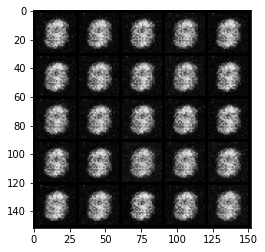

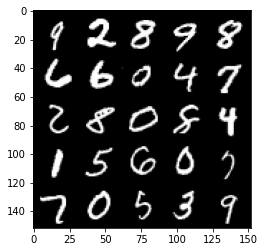

Step 1000: Generator loss: 1.6656246247291555, discriminator loss: 0.2981168535053729


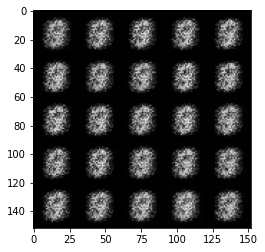

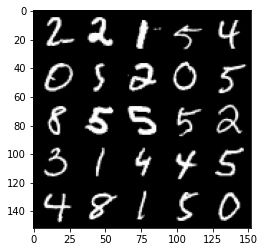

Step 1500: Generator loss: 1.9441871857643114, discriminator loss: 0.1765091420710088


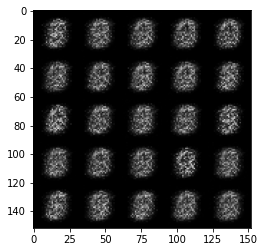

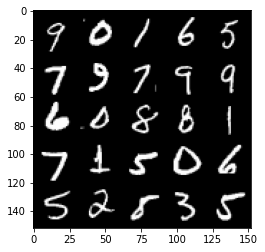

Step 2000: Generator loss: 1.6857188875675202, discriminator loss: 0.2132513333261011


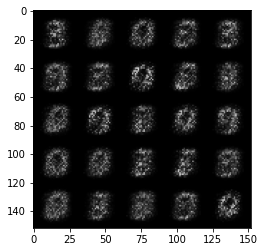

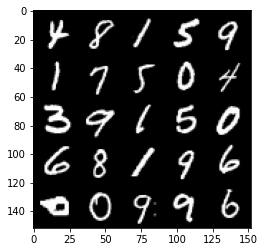

Step 2500: Generator loss: 1.5449774158000937, discriminator loss: 0.2405234483480453


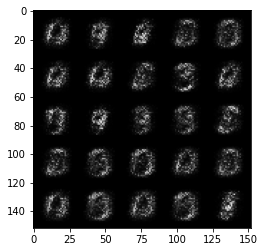

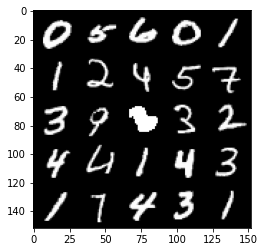

Step 3000: Generator loss: 1.780691039323806, discriminator loss: 0.19645407018065456


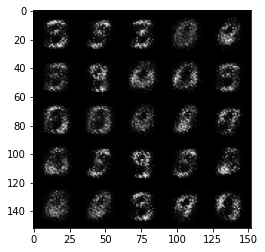

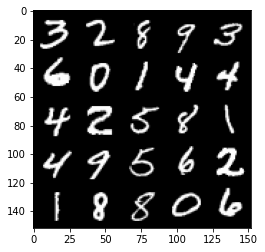

Step 3500: Generator loss: 2.130632097721099, discriminator loss: 0.16816305759549138


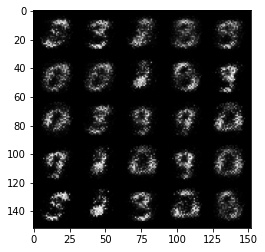

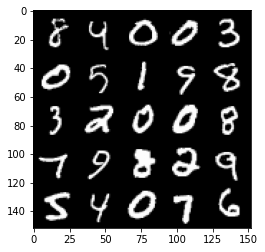

Step 4000: Generator loss: 2.5139318714141834, discriminator loss: 0.13707665579020964


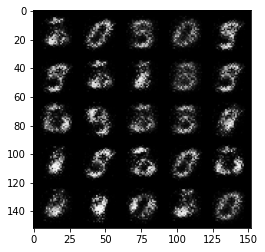

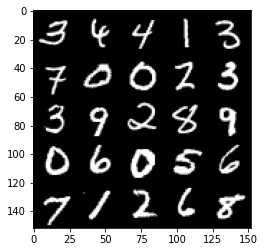

Step 4500: Generator loss: 2.9451286072730998, discriminator loss: 0.09801919616758818


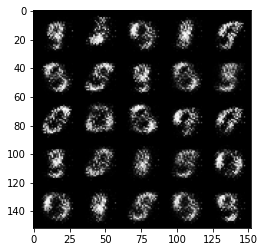

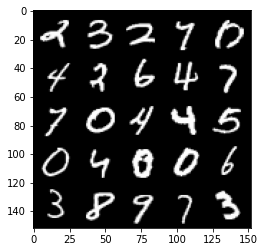

Step 5000: Generator loss: 3.3388862180709857, discriminator loss: 0.07952093540132044


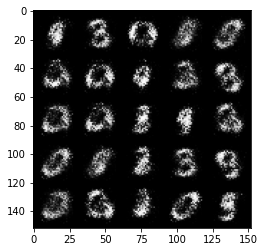

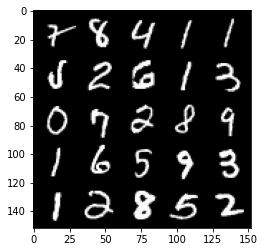

Step 5500: Generator loss: 3.579979014396665, discriminator loss: 0.07133656551688912


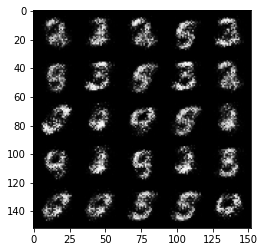

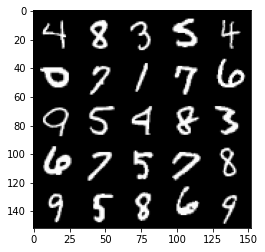

Step 6000: Generator loss: 3.513563856124878, discriminator loss: 0.08347671061754229


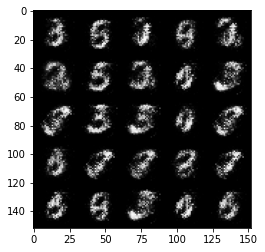

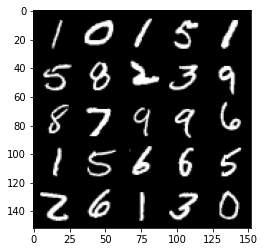

Step 6500: Generator loss: 3.7168718118667585, discriminator loss: 0.07962565778940911


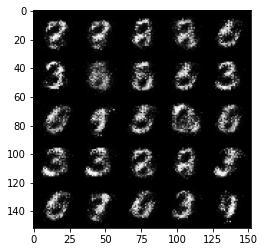

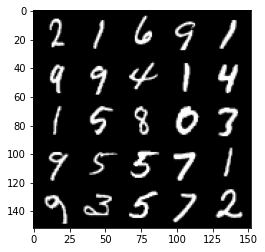

Step 7000: Generator loss: 3.930272888183597, discriminator loss: 0.0738248127922416


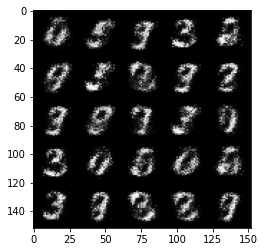

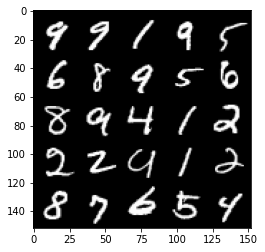

Step 7500: Generator loss: 3.9197050390243553, discriminator loss: 0.06467098492383956


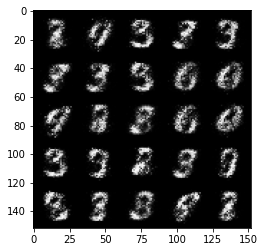

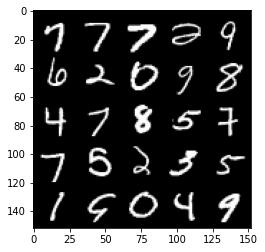

Step 8000: Generator loss: 3.8836646165847766, discriminator loss: 0.07317712714523075


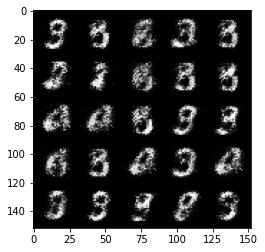

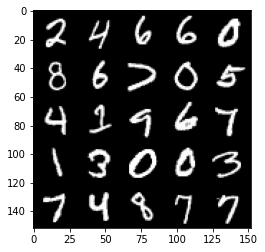

Step 8500: Generator loss: 3.854252407073976, discriminator loss: 0.0758230487704277


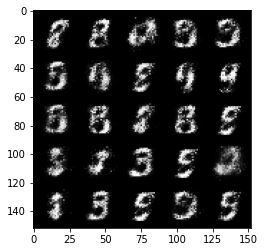

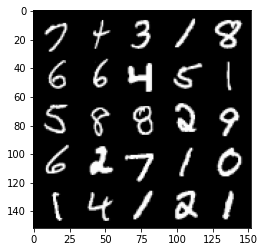

Step 9000: Generator loss: 4.079752078533174, discriminator loss: 0.0654047298505902


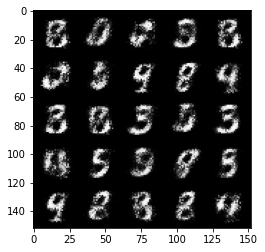

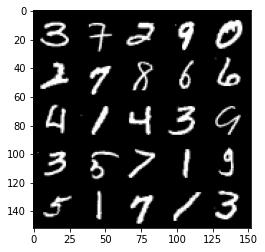

Step 9500: Generator loss: 4.128788695335388, discriminator loss: 0.06053283474594348


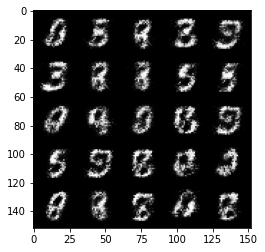

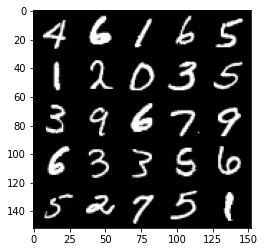

Step 10000: Generator loss: 4.088643097400663, discriminator loss: 0.06916497733443969


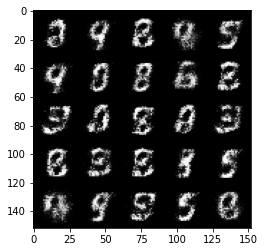

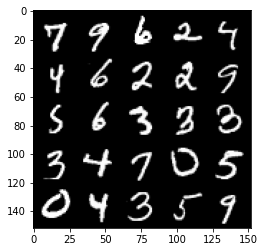

Step 10500: Generator loss: 3.9076620879173287, discriminator loss: 0.0791855874434113


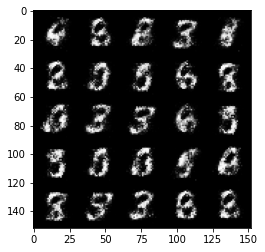

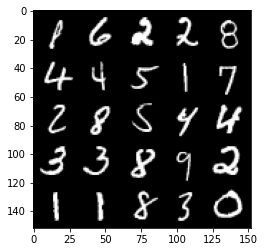

Step 11000: Generator loss: 3.978835525989532, discriminator loss: 0.0835895763188601


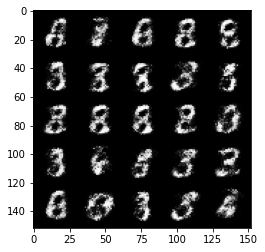

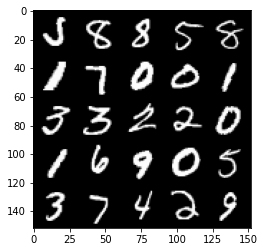

Step 11500: Generator loss: 4.029119150161741, discriminator loss: 0.08116045079380273


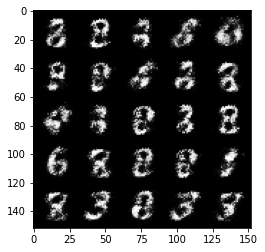

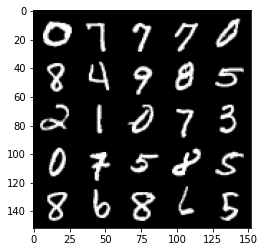

Step 12000: Generator loss: 4.1361296834945716, discriminator loss: 0.07737063279747963


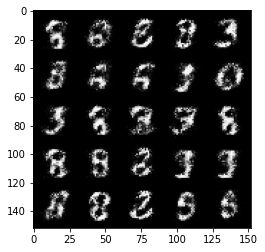

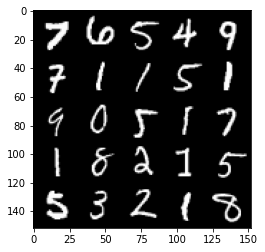

Step 12500: Generator loss: 4.085861532688142, discriminator loss: 0.08443745969980959


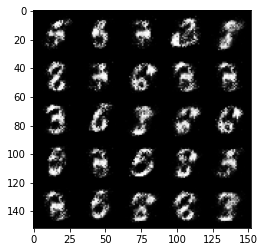

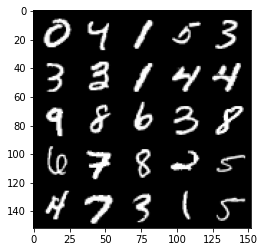

Step 13000: Generator loss: 4.034112292289735, discriminator loss: 0.09713226044178015


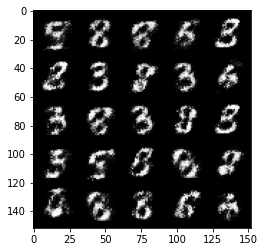

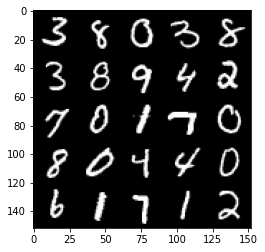

Step 13500: Generator loss: 4.011643434047695, discriminator loss: 0.10003597145527604


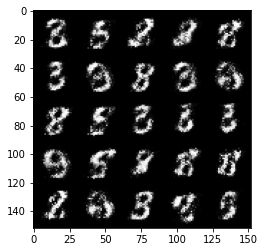

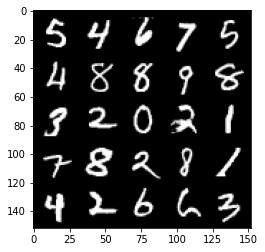

Step 14000: Generator loss: 3.9510984082222, discriminator loss: 0.10003811411559572


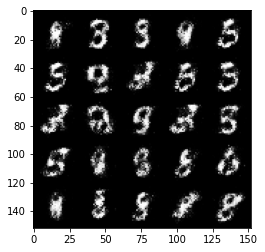

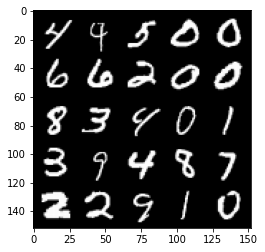

Step 14500: Generator loss: 3.9709547376632677, discriminator loss: 0.10288144693523646


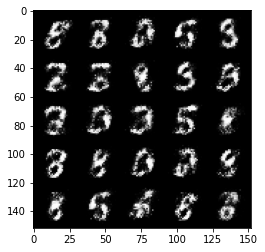

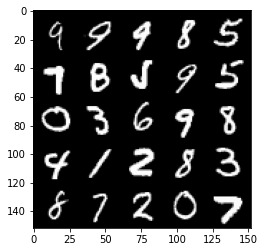

Step 15000: Generator loss: 3.8288143157958987, discriminator loss: 0.11128580413013688


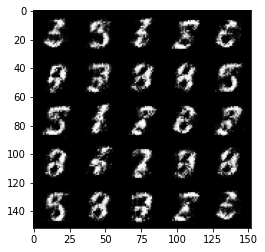

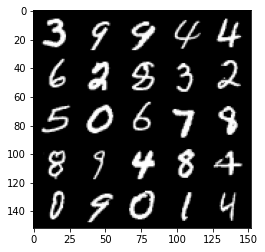

Step 15500: Generator loss: 3.7098482651710505, discriminator loss: 0.10808048192411657


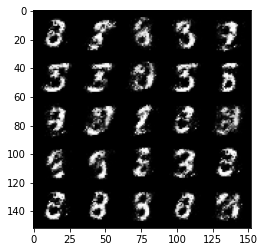

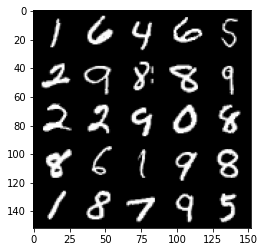

Step 16000: Generator loss: 3.7948022799491863, discriminator loss: 0.1120265289098025


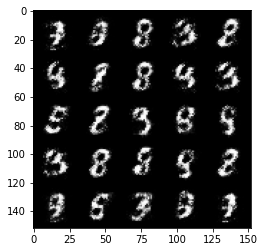

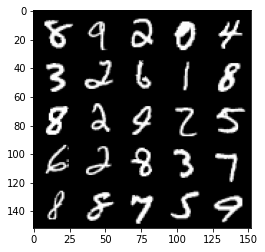

Step 16500: Generator loss: 3.688512317180635, discriminator loss: 0.11398653134703639


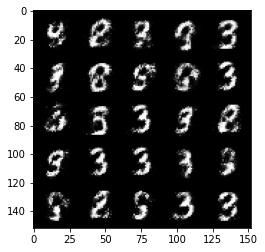

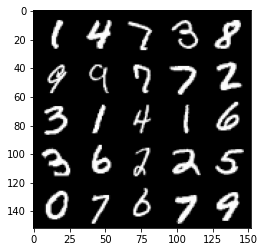

Step 17000: Generator loss: 3.622541139125822, discriminator loss: 0.12832023540139198


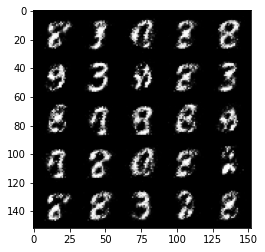

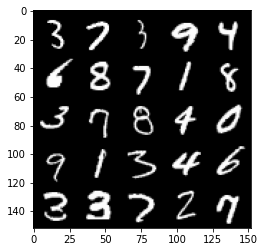

Step 17500: Generator loss: 3.319105179309846, discriminator loss: 0.13981649713218214


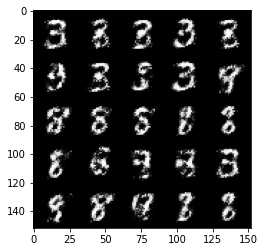

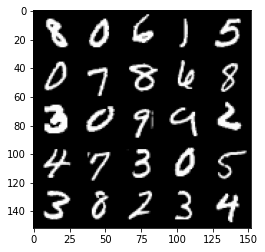

Step 18000: Generator loss: 3.4751878361701953, discriminator loss: 0.13139223141223197


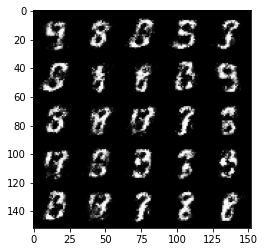

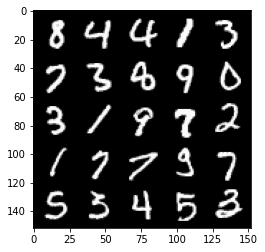

Step 18500: Generator loss: 3.329565846920016, discriminator loss: 0.1566483400315045


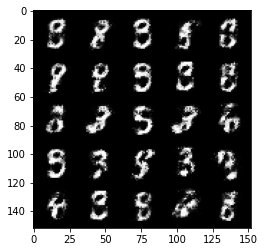

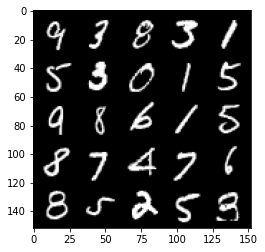

Step 19000: Generator loss: 3.2376009283065805, discriminator loss: 0.1532984219789507


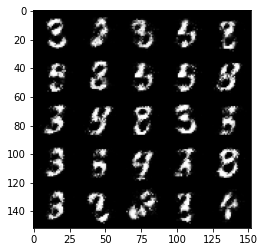

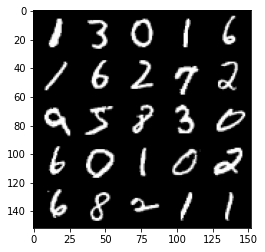

Step 19500: Generator loss: 3.3399321007728595, discriminator loss: 0.1435441832244396


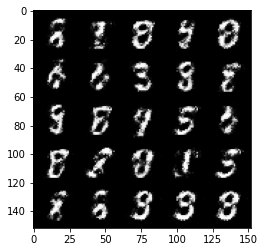

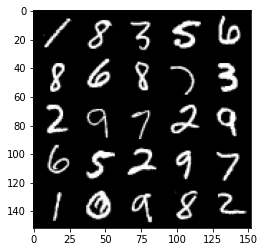

Step 20000: Generator loss: 3.1615757126808135, discriminator loss: 0.15596543288230907


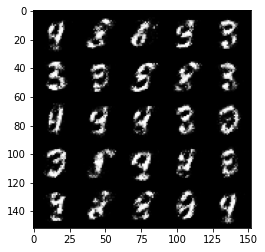

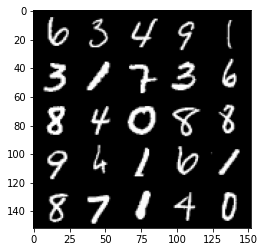

Step 20500: Generator loss: 3.1523600316047644, discriminator loss: 0.17833021183311934


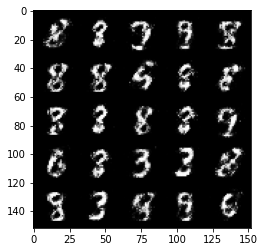

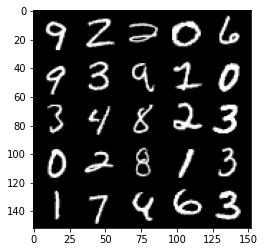

Step 21000: Generator loss: 3.154999849796295, discriminator loss: 0.17156322039663766


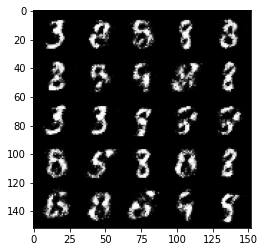

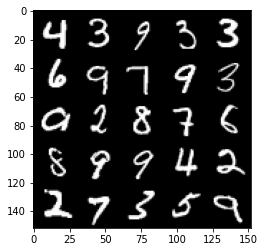

Step 21500: Generator loss: 3.041242022037507, discriminator loss: 0.1669354311227798


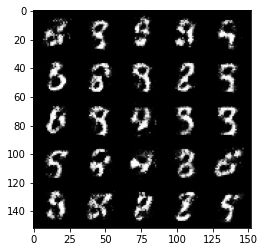

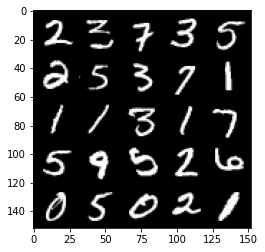

Step 22000: Generator loss: 3.1285155405998233, discriminator loss: 0.16499973085522648


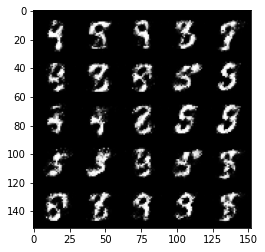

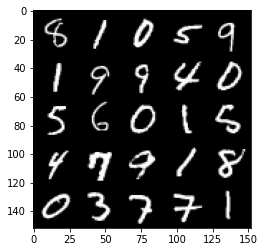

Step 22500: Generator loss: 2.926620863437655, discriminator loss: 0.1930086887329818


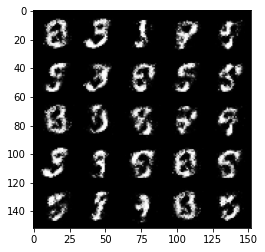

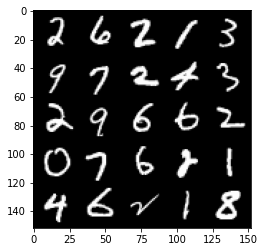

Step 23000: Generator loss: 2.9038355579376214, discriminator loss: 0.19489749376475815


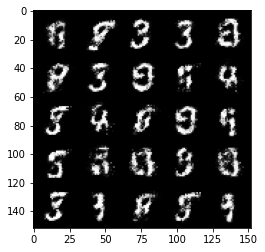

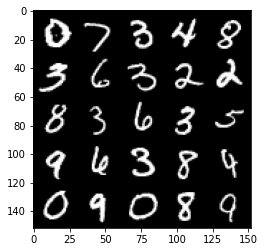

Step 23500: Generator loss: 2.894936520576478, discriminator loss: 0.18510087275505083


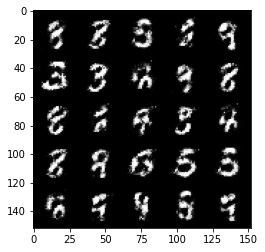

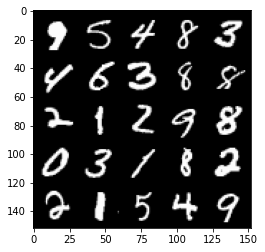

Step 24000: Generator loss: 2.9160919523239137, discriminator loss: 0.1913562325984237


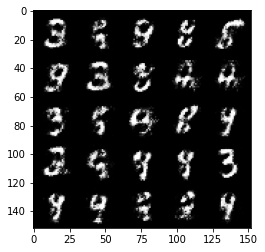

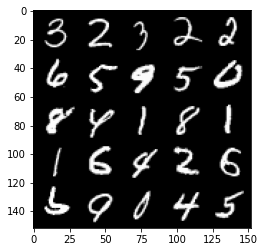

Step 24500: Generator loss: 2.8028601737022387, discriminator loss: 0.20960867528617388


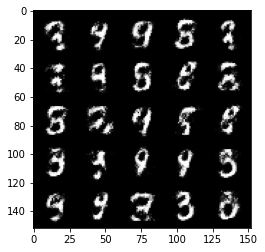

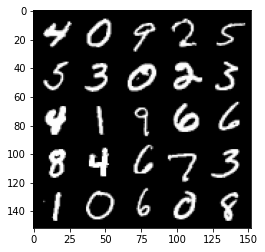

Step 25000: Generator loss: 2.7897890367507943, discriminator loss: 0.22033595898747435


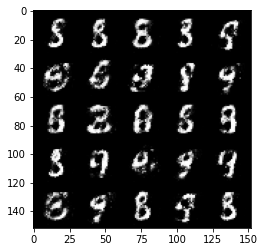

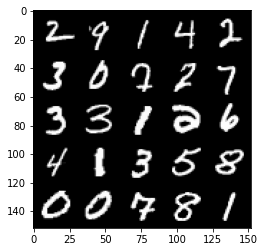

Step 25500: Generator loss: 2.6299841840267186, discriminator loss: 0.2309145977795126


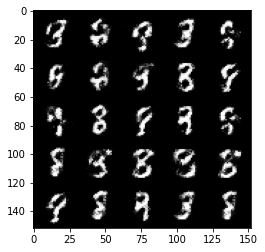

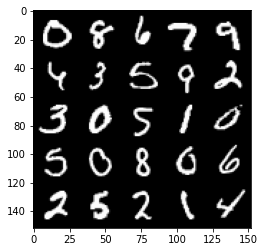

Step 26000: Generator loss: 2.626928292274477, discriminator loss: 0.2231653504073621


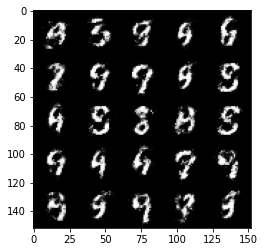

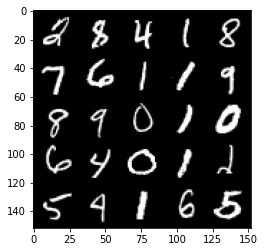

Step 26500: Generator loss: 2.6615825915336604, discriminator loss: 0.21341384652256953


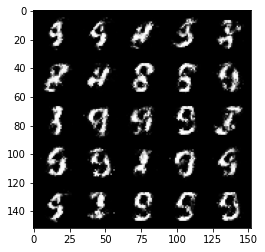

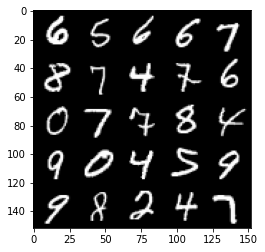

Step 27000: Generator loss: 2.671307824611666, discriminator loss: 0.22325139060616492


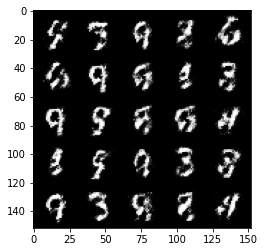

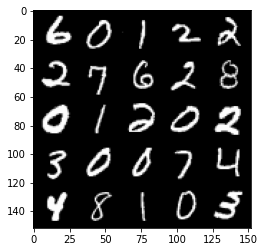

Step 27500: Generator loss: 2.7035683612823496, discriminator loss: 0.21877549803257


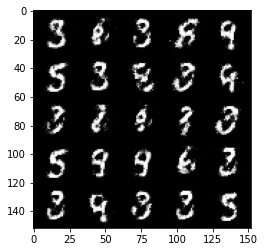

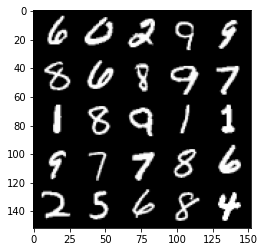

Step 28000: Generator loss: 2.712835975646971, discriminator loss: 0.22231948931515222


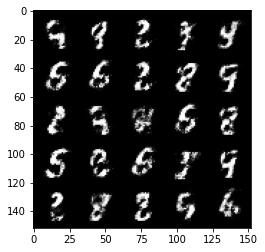

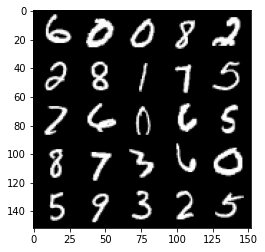

Step 28500: Generator loss: 2.648933903217317, discriminator loss: 0.2227613032460214


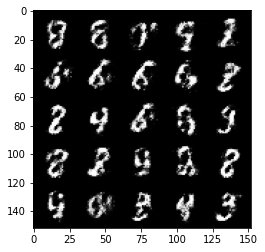

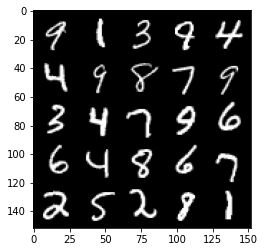

Step 29000: Generator loss: 2.6395272440910316, discriminator loss: 0.22143764895200752


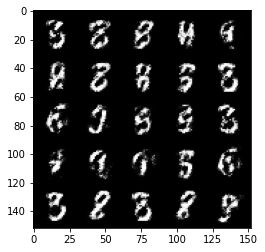

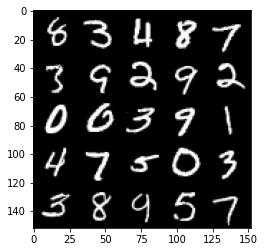

Step 29500: Generator loss: 2.5633243212699917, discriminator loss: 0.2223391216993331


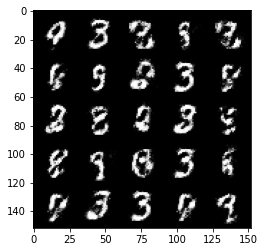

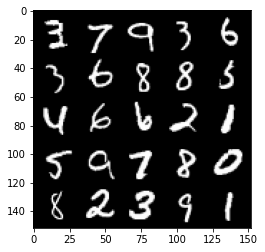

Step 30000: Generator loss: 2.475993861436842, discriminator loss: 0.24349670439958582


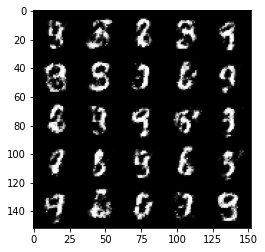

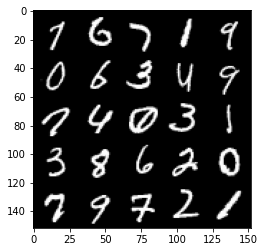

Step 30500: Generator loss: 2.486363048553465, discriminator loss: 0.2405100998282434


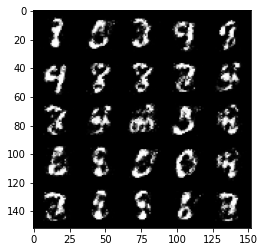

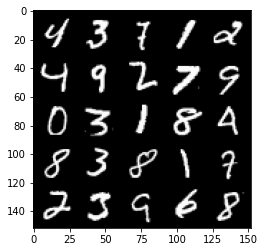

Step 31000: Generator loss: 2.4894723019599905, discriminator loss: 0.2567526505589488


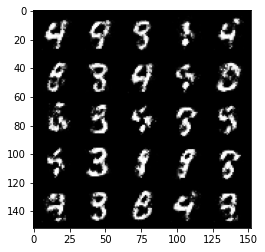

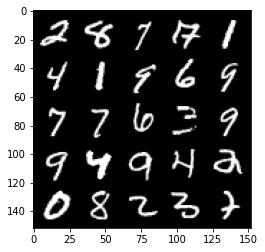

Step 31500: Generator loss: 2.4724828422069582, discriminator loss: 0.24358037200570115


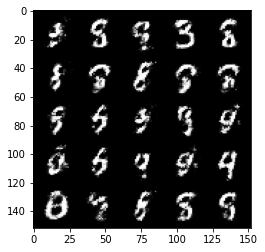

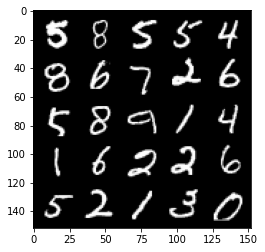

Step 32000: Generator loss: 2.4108007106781013, discriminator loss: 0.2552382827103137


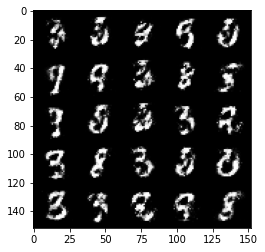

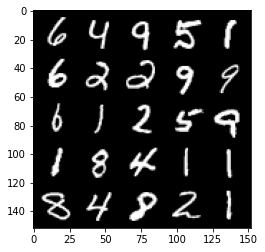

Step 32500: Generator loss: 2.3184734709262838, discriminator loss: 0.26426080974936483


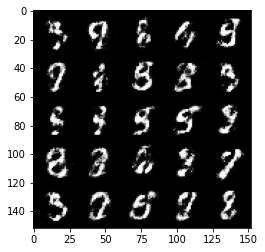

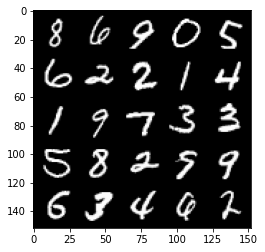

Step 33000: Generator loss: 2.3277554097175583, discriminator loss: 0.2565261114835739


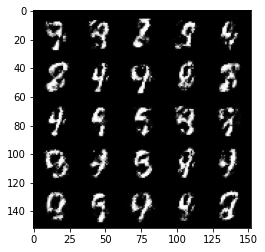

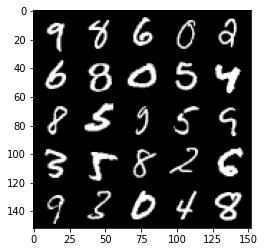

Step 33500: Generator loss: 2.3518612470626827, discriminator loss: 0.26938057723641406


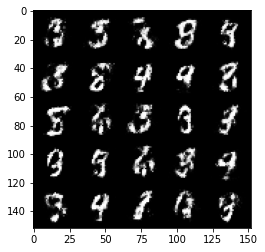

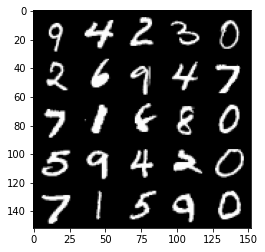

Step 34000: Generator loss: 2.2143778922557846, discriminator loss: 0.2879296726882459


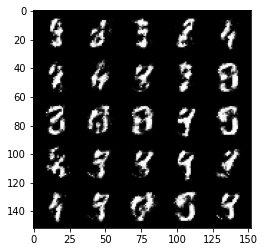

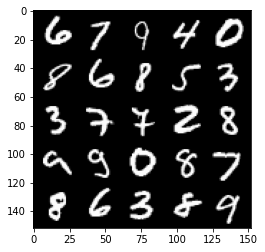

Step 34500: Generator loss: 2.2937290966510786, discriminator loss: 0.2632837039828299


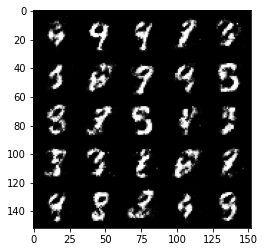

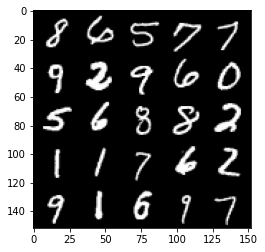

Step 35000: Generator loss: 2.36277156639099, discriminator loss: 0.2578640891015528


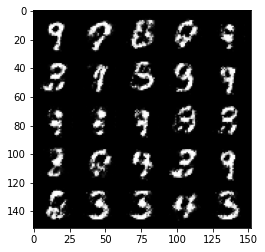

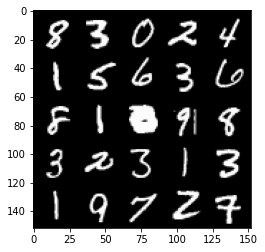

Step 35500: Generator loss: 2.2845055899620057, discriminator loss: 0.2799377426803111


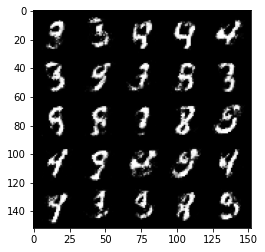

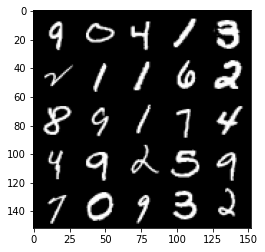

Step 36000: Generator loss: 2.137415235996245, discriminator loss: 0.29911328935623194


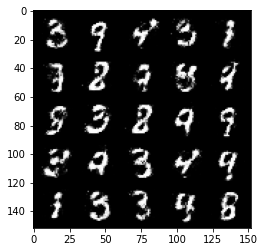

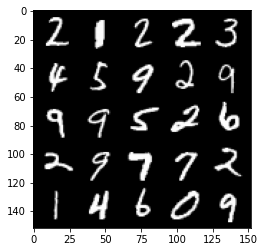

Step 36500: Generator loss: 2.2205180561542512, discriminator loss: 0.2842231841087345


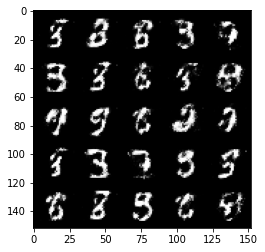

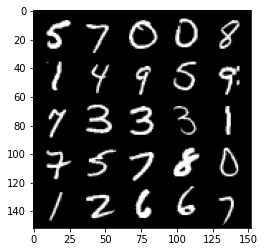

Step 37000: Generator loss: 2.1830067250728593, discriminator loss: 0.2865365295410158


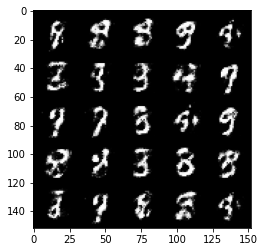

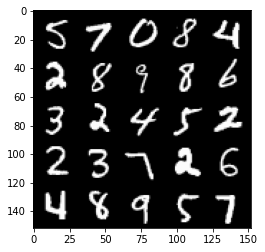

Step 37500: Generator loss: 2.2529306142330183, discriminator loss: 0.263704162836075


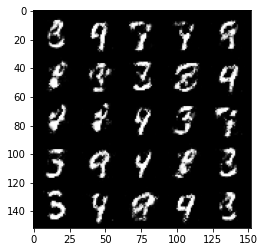

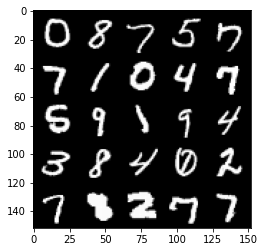

Step 38000: Generator loss: 2.3256557178497337, discriminator loss: 0.25996381711959826


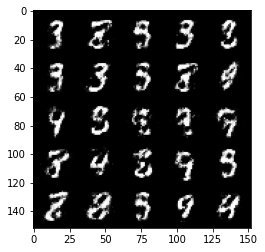

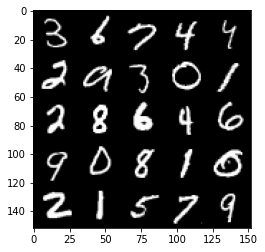

Step 38500: Generator loss: 2.1035424246788033, discriminator loss: 0.2961700534522533


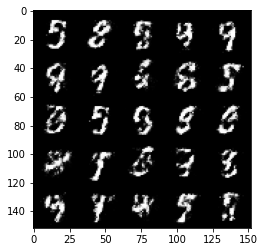

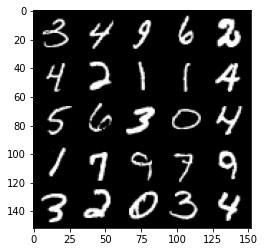

Step 39000: Generator loss: 2.1106766788959495, discriminator loss: 0.29823823997378335


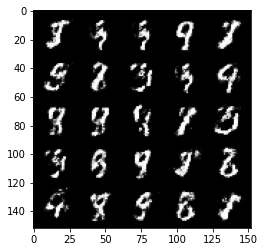

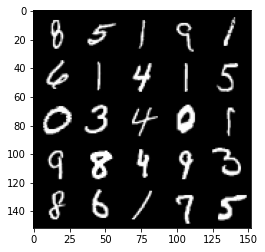

Step 39500: Generator loss: 2.2534390678405765, discriminator loss: 0.2738110918104651


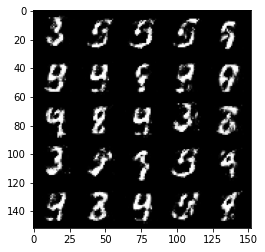

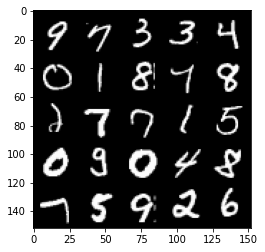

Step 40000: Generator loss: 2.200362012624742, discriminator loss: 0.28079557365179064


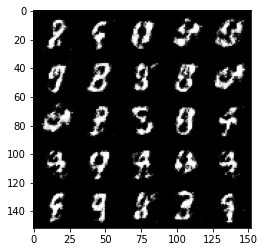

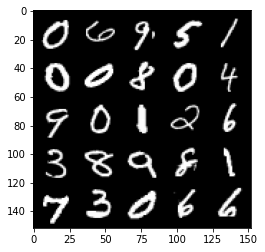

In [ ]:
cur_step = 0
mean_generator_loss = 0
mean_discriminator_loss = 0
test_generator = True # Whether the generator should be tested
gen_loss = False
error = False
for epoch in range(n_epochs):
  
    for real, _ in tqdm(dataloader):
        cur_batch_size = len(real)

        # Flattening the batch of real images from the dataset
        real = real.view(cur_batch_size, -1).to(device)

        ### Update discriminator ###
        # Zero outing the gradients before backpropagation
        disc_opt.zero_grad()

        # Calculating discriminator loss
        disc_loss = get_disc_loss(gen, disc, criterion, real, cur_batch_size, z_dim, device)

        # Updating gradients
        disc_loss.backward(retain_graph=True)

        # Updating optimizer
        disc_opt.step()

        # For testing purposes, to keep track of the generator weights
        if test_generator:
            old_generator_weights = gen.gen[0][0].weight.detach().clone()

        gen_opt.zero_grad()
        gen_loss = get_gen_loss(gen, disc, criterion, cur_batch_size, z_dim, device)
        gen_loss.backward(retain_graph=True)
        gen_opt.step()

        # For testing purposes, to check that the code changes the generator weights
        if test_generator:
            try:
                assert lr > 0.0000002 or (gen.gen[0][0].weight.grad.abs().max() < 0.0005 and epoch == 0)
                assert torch.any(gen.gen[0][0].weight.detach().clone() != old_generator_weights)
            except:
                error = True
                print("Runtime tests have failed")

        # Keeping track of the average discriminator loss
        mean_discriminator_loss += disc_loss.item() / display_step

        # Keeping track of the average generator loss
        mean_generator_loss += gen_loss.item() / display_step

        ### Visualization code ###
        if cur_step % display_step == 0 and cur_step > 0:
            print(f"Step {cur_step}: Generator loss: {mean_generator_loss}, discriminator loss: {mean_discriminator_loss}")
            fake_noise = get_noise(cur_batch_size, z_dim, device=device)
            fake = gen(fake_noise)
            show_tensor_images(fake)
            show_tensor_images(real)
            mean_generator_loss = 0
            mean_discriminator_loss = 0
        cur_step += 1
